<a href="https://colab.research.google.com/github/faezesarlakifar/face-emotion-recognition/blob/main/self_supervised_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision.transforms as transforms
import itertools
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import hamming
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import transforms
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
import shutil
from skimage.transform import rotate
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
import glob
import seaborn as sns
import cv2

**running on GPU**

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


**Define Hyper parameters**

In [ ]:
num_classes = 4 # use for rotation detection pretext and also for our downstream task
dropout_rate = 0.5
learning_rate = 0.01
epochs = 25
batch_size = 32

**Start defining pretext tasks**

In [ ]:
class DataCollator(object):
    def __init__(self):
        pass

    def __call__(self, examples):
        pass

    def _preprocess_batch(self, examples):
        examples = [(example[0], torch.tensor(example[1]).long()) for example in examples]
        if all(x.shape == examples[0][0].shape for x, y in examples):
            x, y = tuple(map(torch.stack, zip(*examples)))
            return x, y
        else:
            raise ValueError('Examples must contain the same shape!')

**Image rotation detection**

In [ ]:
class RotationCollator(DataCollator):
    def __init__(self, num_rotations=4, rotation_procedure='all'):
        super(RotationCollator).__init__()
        self.num_rotations = num_rotations
        self.rotation_degrees = np.linspace(0, 360, num_rotations + 1).tolist()[:-1]

        assert rotation_procedure in ['all', 'random']
        self.rotation_procedure = rotation_procedure

    def __call__(self, examples):

        batch = self._preprocess_batch(examples)
        x, y = batch
        batch_size = x.shape[0]

        if self.rotation_procedure == 'random':
            for i in range(batch_size):
                theta = np.random.choice(self.rotation_degrees, size=1)[0]
                x[i] = self.rotate_image(x[i].unsqueeze(0), theta=theta).squeeze(0)
                y[i] = torch.tensor(self.rotation_degrees.index(theta)).long()

        elif self.rotation_procedure == 'all':
            x_, y_ = [], []
            for theta in self.rotation_degrees:
                x_.append(self.rotate_image(x.clone(), theta=theta))
                y_.append(torch.tensor(self.rotation_degrees.index(theta)).long().repeat(batch_size))

            x, y = torch.cat(x_), torch.cat(y_)

            # Shuffle images and labels to get rid of the fixed [0, 90, 180, 270] order
            permutation = torch.randperm(batch_size * 4)
            x, y = x[permutation], y[permutation]

        return x, y

    @staticmethod
    def get_rotation_matrix(theta, mode='degrees'):
        assert mode in ['degrees', 'radians']

        if mode == 'degrees':
            theta *= np.pi / 180

        theta = torch.tensor(theta)
        return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                             [torch.sin(theta), torch.cos(theta), 0]])

    def rotate_image(self, x, theta):
        dtype = x.dtype
        rotation_matrix = self.get_rotation_matrix(theta=theta, mode='degrees')[None, ...].type(dtype).repeat(x.shape[0], 1, 1)
        grid = F.affine_grid(rotation_matrix, x.shape, align_corners=True).type(dtype)
        x = F.grid_sample(x, grid, align_corners=True)
        return x


**Jigsaw puzzle**

In [ ]:
class JigsawCollator(DataCollator):

    def __init__(self, num_tiles=9, num_permutations=1000, permgen_method='maximal',
                 grayscale_probability=0.3, buffer=True, jitter=True, normalization=True):
        super(JigsawCollator).__init__()
        # Make sure num. tiles is a number whose square root is an integer (i.e. perfect square)
        assert num_tiles % np.sqrt(num_tiles) == 0
        self.num_tiles = num_tiles
        self.num_permutations = num_permutations

        assert 0. <= grayscale_probability <= 1.
        self.grayscale_probability = grayscale_probability

        self.buffer = buffer
        self.jitter = jitter
        self.normalization = normalization

        # Randomly pick `k` permutations for tile configurations (i.e. the permutation set)
        # NOTE: We assign indices to each tile configuration with the list `self.permutations
        self.permutations = self.generate_permutation_set(num_tiles=num_tiles,
                                                          num_permutations=num_permutations,
                                                          method=permgen_method)

    def __call__(self, examples):
        """
        Makes the class callable, just like a function.
        """
        batch = self._preprocess_batch(examples)
        x, _ = batch
        batch_size, img_height, img_width = x.shape[0], x.shape[-2], x.shape[-1]

        # Make sure that the image is square; jigsaw puzzles are for squares
        assert img_height == img_width

        # Apply random grayscaling to avoid shortcuts due to chromatic aberration
        for i in range(batch_size):
            if np.random.rand() <= self.grayscale_probability:
                x[i] = self.rgb2grayscale(x[i]).repeat(3, 1, 1)

        # Compute the tile length and extract the tiles
        tiles = []
        num_tiles_per_dimension = int(np.sqrt(self.num_tiles))
        tile_length = img_width // num_tiles_per_dimension

        buffer = int(tile_length * 0.1)

        for i in range(num_tiles_per_dimension):
            for j in range(num_tiles_per_dimension):
                if self.buffer:
                    tile_ij = torch.empty(batch_size, x.shape[1], tile_length - buffer, tile_length - buffer)
                else:
                    tile_ij = x[:, :, i * tile_length: (i + 1) * tile_length, j * tile_length: (j + 1) * tile_length]

                for k in range(batch_size):
                    num_channels = tile_ij.shape[1]

                    # Leave a random gap between tiles to avoid shortcuts due to edge continuity
                    if self.buffer:
                        # Randomly sample values that sum up to `buffer` for cropping
                        # NOTE: The summing up helps keep the same cropped tile size
                        buffer_x1, buffer_x2 = np.random.multinomial(buffer, [0.5, 0.5])
                        buffer_y1, buffer_y2 = np.random.multinomial(buffer, [0.5, 0.5])

                        tile_x1 = i * tile_length + buffer_x1
                        tile_x2 = (i + 1) * tile_length - buffer_x2
                        tile_y1 = j * tile_length + buffer_y1
                        tile_y2 = (j + 1) * tile_length - buffer_y2

                        tile_ij[k] = x[k, :, tile_x1: tile_x2, tile_y1: tile_y2]

                    # Apply random spatial jitter to avoid shortcuts due to chromatic aberration
                    if self.jitter and num_channels == 3:
                        tile_ij[k] = torch.stack([torch.roll(tile_ij[k, 0], random.randint(-2, 2)),
                                                  torch.roll(tile_ij[k, 1], random.randint(-2, 2)),
                                                  torch.roll(tile_ij[k, 2], random.randint(-2, 2))])

                    # Apply normalization to avoid shortcuts due to low-level statistics
                    if self.normalization:
                        # NOTE: The normalization is independently applied to each image patch
                        normalization = transforms.Normalize([tile_ij[k, c].mean() for c in range(num_channels)],
                                                             [tile_ij[k, c].std() for c in range(num_channels)])
                        tile_ij[k] = normalization(tile_ij[k])

                tiles.append(tile_ij)

        # Tensorize the tiles
        tiles = torch.stack(tiles)

        # Shuffle tiles according to a randomly drawn in sequence in the permutations list
        y = []
        for i in range(batch_size):
            permutation_index = np.random.randint(0, self.num_permutations)
            permutation = torch.tensor(self.permutations[permutation_index])

            tiles[:, i, :, :] = tiles[permutation, i, :, :]
            y.append(permutation_index)

        y = torch.tensor(y).long()

        return tiles, y

    @staticmethod
    def rgb2grayscale(img):

        r_factor, g_factor, b_factor = 0.2126, 0.7152, 0.0722
        return r_factor * img[0:1, :, :] + g_factor * img[1:2, :, :] + b_factor * img[2:3, :, :]

    @staticmethod
    def generate_permutation_set(num_tiles, num_permutations, method='maximal'):
        """
        Function for generating a permutation set based on a Hamming distance based objective.
        Follows the pseudocode given by the authors in the paper.
        """
        if method not in ['maximal', 'average', 'minimal']:
            raise ValueError('The specified method=%s is not recognized!' % method)

        # Initialize the output set
        permutations = []

        # Get all permutations
        tile_positions = list(range(num_tiles))
        all_permutations = list(itertools.permutations(tile_positions))

        # Convert `all_permutations` to a 2D matrix
        all_permutations = np.array(all_permutations).T  # num_tiles x (num_tiles)! matrix

        # Uniformly sample out of (num_tiles)! indices to initialize
        current_index = random.randint(0, np.math.factorial(num_tiles) - 1)

        for i in tqdm(range(1, num_permutations + 1), desc='Generating Permutation Set'):
            # Add permutation at current index to the output set
            permutations.append(tuple(all_permutations[:, current_index]))
            # Remove permutation at current index from `all_permutations`
            all_permutations = np.delete(all_permutations, current_index, axis=1)

            # Uniformly sample all the way if `method` is average and skip computations
            if method == 'average':
                current_index = random.randint(0, np.math.factorial(num_tiles) - i)
                continue

            # Compute the Hamming distance matrix
            distances = np.empty((i, np.math.factorial(num_tiles) - i))

            # TODO: This nested loop takes a very long time!
            for j in range(i):
                for k in range(np.math.factorial(num_tiles) - i):
                    distances[j, k] = hamming(permutations[j], all_permutations[:, k])

            # Convert the matrix into a (summed) row vector of shape 1 x ((num_tiles)! - i)
            distances = np.matmul(np.ones((1, i)), distances)

            # Choose the next permutation s.t. it maximizes the objective
            if method == 'maximal':
                current_index = np.argmax(distances)
            elif method == 'minimal':
                current_index = np.argmin(distances)

        # Compute the minimum hamming distance in the generated permutation set
        distances_ = []
        for i in range(num_permutations):
            for j in range(num_permutations):
                if i != j:
                    distances_.append(hamming(np.array(permutations[i]), np.array(permutations[j])))

        min_distance = min(distances_)
        print('Minimum hamming distance is chosen as %0.4f' % min_distance)

        return permutations

In [ ]:
MODEL_URLS = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'}


class AlexNetBase(nn.Module):
    """
    Implements Base AlexNet with optional batch normalization.
    :param (bool) batch_norm: set to True to apply batch normalization
    """
    def __init__(self, batch_norm=True):
        super(AlexNetBase, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                                      nn.BatchNorm2d(64) if batch_norm else nn.Identity(),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(64, 192, kernel_size=5, padding=2),
                                      nn.BatchNorm2d(192) if batch_norm else nn.Identity(),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(192, 384, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(384) if batch_norm else nn.Identity(),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(384, 256, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(256) if batch_norm else nn.Identity(),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(256) if batch_norm else nn.Identity(),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # Remove any potential nn.Identity() layers
        self.features = nn.Sequential(*[child for child in self.features.children() if not isinstance(child, nn.Identity)])

    def forward(self, x):
        x = self.features(x)
        if x.shape != (x.shape[0], 256, 6, 6):
            x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x


In [ ]:
class ClassificationHead(nn.Module):

    def __init__(self, num_classes=1000, batch_norm=True, dropout_rate=0.5):
        super(ClassificationHead, self).__init__()
        self.classifier = nn.Sequential(nn.Dropout() if dropout_rate > 0. else nn.Identity(),
                                        nn.Linear(256 * 6 * 6, 4096, bias=False if batch_norm else True),
                                        nn.BatchNorm1d(4096) if batch_norm else nn.Identity(),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout() if dropout_rate > 0. else nn.Identity(),
                                        nn.Linear(4096, 4096, bias=False if batch_norm else True),
                                        nn.BatchNorm1d(4096) if batch_norm else nn.Identity(),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(4096, num_classes))

        # Remove any potential nn.Identity() layers
        self.classifier = nn.Sequential(*[child for child in self.classifier.children() if not isinstance(child, nn.Identity)])

    def forward(self, x):
        x = self.classifier(x)
        return x

In [ ]:
class AlexNetRotation(nn.Module):
    """
    Implements AlexNet model for self-supervised rotation classification task.
    """
    def __init__(self, num_rotations=4):
        super(AlexNetRotation, self).__init__()
        self.model = nn.ModuleList([AlexNetBase(batch_norm=True),
                                    ClassificationHead(num_classes=num_rotations,
                                                       batch_norm=True,
                                                       dropout_rate=dropout_rate)])

    def forward(self, x):
        out = self.model[0](x)  # base
        out = self.model[1](out)  # head
        return out

In [ ]:
class AlexNetJigsaw(nn.Module):
    """
    Implements AlexNet model for self-supervised jigsaw puzzle task.
    :param (int) num_tiles: number of tiles to divide each image to for the puzzle
    :param (int) num_permutations: number of permutations to arrange the tiles
    """
    def __init__(self, num_tiles=9, num_permutations=1000):
        super(AlexNetJigsaw, self).__init__()

        # Make sure num. tiles is a number whose square root is an integer (i.e. perfect square)
        assert num_tiles % np.sqrt(num_tiles) == 0
        self.num_tiles = num_tiles

        # TODO: During self-supervised pretraining authors use stride 2 for the first CONV layer
        self.siamese_network = nn.ModuleList([AlexNetBase(batch_norm=True),
                                              nn.Linear(256 * 6 * 6, 512, bias=False),
                                              nn.BatchNorm1d(512),
                                              nn.ReLU(inplace=True)])

        self.classifier = nn.ModuleList([nn.Linear(512 * num_tiles, 4096, bias=False),
                                         nn.BatchNorm1d(4096),
                                         nn.ReLU(inplace=True),
                                         nn.Linear(4096, num_permutations)])

    def forward(self, x):
        assert x.shape[0] == self.num_tiles
        device = x.device

        x = torch.stack([self.siamese_network(tile) for tile in x]).to(device)
        x = x.view(x.shape[1], -1)  # concatenate features from different tiles
        x = self.classifier(x)
        return x


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

def tensor2PIL(torch_img):
    return transforms.ToPILImage()(torch_img.squeeze(0))

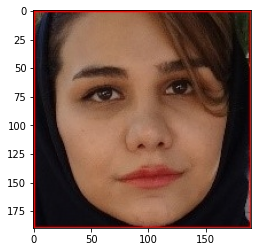

In [ ]:
img = Image.open(os.path.join('face2.jpg')).convert('RGB')
plt.imshow(img)
plt.show()

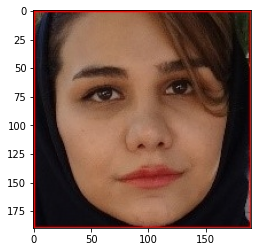

In [ ]:
torch_img = transform(img).unsqueeze(0)
plt.imshow(tensor2PIL(torch_img))
plt.show()

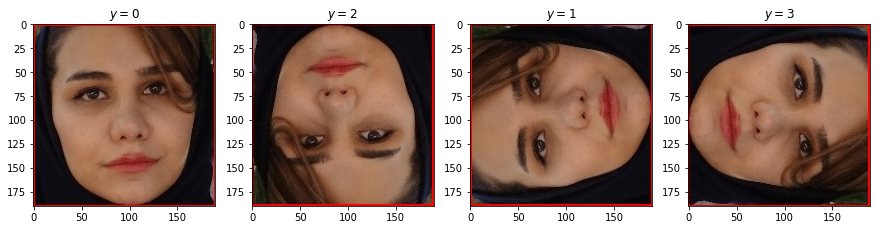

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 12))

collator = RotationCollator(num_rotations=4, rotation_procedure='all')
x, y = collator([[torch_img.squeeze(0), -1]])

for i in range(x.shape[0]):
    ax[i].set_title(r'$y=%d$' % y[i])
    ax[i].imshow(tensor2PIL(x[i]))

plt.show()



# Load Data
* make dataLoader

**rotation of 90 clockwise**

In [ ]:
import cv2
data_dir = r'./validated_detected_face/'
dst_dir = r'new_rotated_Dataset/rotation1/'

try:
	# creating a folder named data
    if not os.path.exists('new_rotated_Dataset/rotation1'):
        os.makedirs('new_rotated_Dataset/rotation1')

# if not created then raise error
except OSError:
    print ('Error: Creating directory of new_rotated_Dataset/rotation1')

currentImg = 0
for filename in os.listdir(data_dir):

        image = cv2.imread(os.path.join(data_dir,filename))
        image_norm = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

        name = 'new_rotated_Dataset/rotation1/r1-num' + str(currentImg) + '.jpg'
        print ('Creating...' + name)
        cv2.imwrite(name, image_norm)

        currentImg += 1

**rotation of 270 clockwise**

In [ ]:
import cv2
data_dir = r'./validated_detected_face/'
dst_dir = r'new_rotated_Dataset/rotation2/'

try:
	# creating a folder named data
    if not os.path.exists('new_rotated_Dataset/rotation2'):
        os.makedirs('new_rotated_Dataset/rotation2')

# if not created then raise error
except OSError:
    print ('Error: Creating directory of new_rotated_Dataset/rotation2')

currentImg = 0
for filename in os.listdir(data_dir):

        image = cv2.imread(os.path.join(data_dir,filename))
        image_norm1 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        image_norm2 = cv2.rotate(image_norm1, cv2.ROTATE_90_CLOCKWISE)
        image_norm = cv2.rotate(image_norm2, cv2.ROTATE_90_CLOCKWISE)

        name = 'new_rotated_Dataset/rotation2/r2-num' + str(currentImg) + '.jpg'
        print ('Creating...' + name)
        cv2.imwrite(name, image_norm)

        currentImg += 1

**rotation of 180 clockwise**

In [ ]:
import cv2
data_dir = r'./validated_detected_face/'
dst_dir = r'new_rotated_Dataset/rotation3/'

try:
	# creating a folder named data
    if not os.path.exists('new_rotated_Dataset/rotation3'):
        os.makedirs('new_rotated_Dataset/rotation3')

# if not created then raise error
except OSError:
    print ('Error: Creating directory of new_rotated_Dataset/rotation3')

currentImg = 0
for filename in os.listdir(data_dir):

        image = cv2.imread(os.path.join(data_dir,filename))
        image_norm1 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        image_norm = cv2.rotate(image_norm1, cv2.ROTATE_90_CLOCKWISE)

        name = 'new_rotated_Dataset/rotation3/r3-num' + str(currentImg) + '.jpg'
        print ('Creating...' + name)
        cv2.imwrite(name, image_norm)

        currentImg += 1


In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = r'new_rotated_Dataset/'
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            print("calss name: ", class_name)
            for img_path in glob.glob(class_path + "\*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        #self.class_map = {"Others" : 0, "Human_Face": 1 }
        self.class_map = { "rotation_0": 0, "rotation_90": 1, "rotation_180": 2, "rotation_270":3 }
        self.img_dim = (128, 128)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

**create data loader**

In [ ]:
    dataset = CustomDataset()
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

['new_rotated_Dataset\\rotation_0', 'new_rotated_Dataset\\rotation_180', 'new_rotated_Dataset\\rotation_270', 'new_rotated_Dataset\\rotation_90']
calss name:  rotation_0
calss name:  rotation_180
calss name:  rotation_270
calss name:  rotation_90
[['new_rotated_Dataset\\rotation_180\\r3-num1.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num10.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num100.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num1000.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num1001.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num1002.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num1003.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num1004.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num1005.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num1006.jpg', 'rotation_180'], ['new_rotated_Dataset\\rotation_180\\r3-num1007.

# Image Rotation detection pretext
**Train the model for Image Rotation detection pretext task**

* first define Optimizer, Loss function and scheduler



In [ ]:
model = AlexNetRotation()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, [5, 10])
#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()


loss_values = []
running_loss = 0.0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(data_loader):
        # Move tensors to the configured device
        labels = labels.to(device)
        labels = labels.float()
        #print(images)
        #print(labels)
        # Forward pass
        outputs = model(images.float())

      #  print(outputs)
        #print(outputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_values.append(loss.item())

    print('Epoch [{}/{}]: Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([21, 1])) that is different to the input size (torch.Size([21, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/25]: Loss: 0.7716
Epoch [2/25]: Loss: 0.7610
Epoch [3/25]: Loss: 1.3044
Epoch [4/25]: Loss: 0.5846
Epoch [5/25]: Loss: 0.3536
Epoch [6/25]: Loss: 0.4313
Epoch [7/25]: Loss: 0.1363
Epoch [8/25]: Loss: 0.2470
Epoch [9/25]: Loss: 0.1565
Epoch [10/25]: Loss: 0.0749
Epoch [11/25]: Loss: 0.0911
Epoch [12/25]: Loss: 0.0634
Epoch [13/25]: Loss: 0.1197
Epoch [14/25]: Loss: 0.0107
Epoch [15/25]: Loss: 0.1036
Epoch [16/25]: Loss: 0.0162
Epoch [17/25]: Loss: 0.0480
Epoch [18/25]: Loss: 0.1170
Epoch [19/25]: Loss: 0.0017
Epoch [20/25]: Loss: 0.0066
Epoch [21/25]: Loss: 0.0055
Epoch [22/25]: Loss: 0.0330
Epoch [23/25]: Loss: 0.0375
Epoch [24/25]: Loss: 0.0369
Epoch [25/25]: Loss: 0.0120


**saving the model and load it again**

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

base_model = AlexNetRotation() # we do not specify pretrained=True, i.e. do not load default weights
base_model.load_state_dict(torch.load('model_weights.pth'))

# Jigsaw puzzle
* train with AlexNet

In [ ]:
model = AlexNetJigsaw()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, [5, 10])
#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()


loss_values = []
running_loss = 0.0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(data_loader):
        # Move tensors to the configured device
        labels = labels.to(device)
        labels = labels.float()
        #print(images)
        #print(labels)
        # Forward pass
        outputs = model(images.float())

      #  print(outputs)
        #print(outputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_values.append(loss.item())

    print('Epoch [{}/{}]: Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

In [ ]:
torch.save(model.state_dict(), 'model_weights2.pth')

final_base_model = AlexNetRotation() # we do not specify pretrained=True, i.e. do not load default weights
final_base_model.load_state_dict(torch.load('model_weights2.pth'))

# Emotion Detection
* our downstream task
* load our small labeled dataset
* train the pre-trained model use this dataset
* show results and testing

In [ ]:
data_dir = r'./direct_labeled_dataset/train/'

class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = r'direct_labeled_dataset\train/'
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            print("calss name: ", class_name)
            for img_path in glob.glob(class_path + "\*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = { "happy": 0, "sad": 1, "angry": 2, "normal":3 }
        self.img_dim = (128, 128)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

**Set Hyper parameters**

In [ ]:
num_classes = 4 # use for rotation detection pretext and also for our downstream task
dropout_rate = 0.2
learning_rate = 0.003
epochs = 40
batch_size = 8

**train data loader**

In [ ]:
data_final_train = CustomDataset()
data_loader_final_train = DataLoader(data_final_train, batch_size=batch_size, shuffle=True)


In [ ]:
data_dir = r'./direct_labeled_dataset/test/'

class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = r'direct_labeled_dataset\test/'
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            print("calss name: ", class_name)
            for img_path in glob.glob(class_path + "\*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = { "happy": 0, "sad": 1, "angry": 2, "normal":3 }
        self.img_dim = (128, 128)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

**test data loader**

In [ ]:
data_final_test = CustomDataset()
data_loader_final_test = DataLoader(data_final_test, batch_size=batch_size, shuffle=True)

# train model for downstream task
* define optimizer, loss function and scheduler

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, [5, 10])
#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()

In [ ]:
# Train the model
model = final_base_model
model.train()
loss_values = []
running_loss = 0.0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(data_loader_final_train):
        # Move tensors to the configured device
        labels = labels.to(device)
        labels = labels.float()
        #print(images)
        #print(labels)
        # Forward pass
        outputs = model(images.float())
      #  print(outputs)
        #print(outputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_values.append(loss.item())

    print('Epoch [{}/{}]: Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

**Plot training loss**

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
hist = []
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(5)
fig.set_figwidth(10)
plt.plot(np.array(loss_values))

# testing
* use a kaggle dataset for testing
* load dataset
* customize it

In [ ]:
import pandas as pd

""" emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear',
                         3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
                         """
# emotions we need, are 0, 3, 4 and 6

data = pd.read_csv(r'C:/Users/ASUS/Downloads/fer2013.csv', encoding='utf-8')
data = data[['pixels', 'emotion']]
data.head()

In [ ]:
df0 = pd.DataFrame(data)
df1 = df0[df0.emotion != 2]
df2 = df1[df1.emotion != 1]
df = df2[df2.emotion != 5]
df.head()

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)


# labels are:  "happy": 0, "sad": 1, "angry": 2, "normal":3
with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in data_loader_final_test:
            labels = labels.to(device)

            outputs = model(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            acc = correct / total
        print('Accuracy of the network on the test images: {} %'.format(acc * 10))

In [ ]:
data_dir = r'./test/'

class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = r'direct_labeled_dataset\test/'
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("\\")[-1]
            print("calss name: ", class_name)
            for img_path in glob.glob(class_path + "\*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = { "happy": 0, "sad": 1, "angry": 2, "normal":3 }
        self.img_dim = (128, 128)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [ ]:
final_test = CustomDataset()
final_test_loader = DataLoader(final_test, batch_size=16, shuffle=True)

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)


# labels are:  "happy": 0, "sad": 1, "angry": 2, "normal":3
with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in final_test_loader:
            labels = labels.to(device)

            outputs = model(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            acc = correct / total
        print('Accuracy of the network on the test images: {} %'.format(acc*100))

Accuracy of the network on the test images: 75.2 %
